In [1]:
#!pip install pandas_datareader 
import pandas as pd
from pandas_datareader.data import DataReader
from datetime import date 
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Datos

data = ['ETH-USD','BTC-USD'] 
cripto = DataReader(data, 'yahoo', start=date(2014,9,17))
bitcoin = pd.DataFrame(cripto['Close']['BTC-USD'])

#####################################
short = 30
long = 100
#####################################

bitcoin['short'] = bitcoin['BTC-USD'].rolling(window=short).mean()
bitcoin['long'] = bitcoin['BTC-USD'].rolling(window=long).mean()
bitcoin = bitcoin[bitcoin['long'].notnull()]

# Algoritmo

def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1
  for i in range(0,len(signal)):
      if signal['short'][i] > signal['long'][i]:
        if flag != 1:
          sigPriceBuy.append(signal['BTC-USD'][i])
          sigPriceSell.append(np.nan)
          flag = 1
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
        #print('Buy')
      elif signal['short'][i] < signal['long'][i]:
        if flag != 0:
          sigPriceSell.append(signal['long'][i])
          sigPriceBuy.append(np.nan)
          flag = 0
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
        #print('sell')
      else: #Handling nan values
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)

# Aplicamos algoritmo

signal = bitcoin.copy()
print(signal.shape)
x = buy_sell(signal)
signal['Buy_Signal_Price'] = x[0]
signal['Sell_Signal_Price'] = x[1]

(2882, 3)


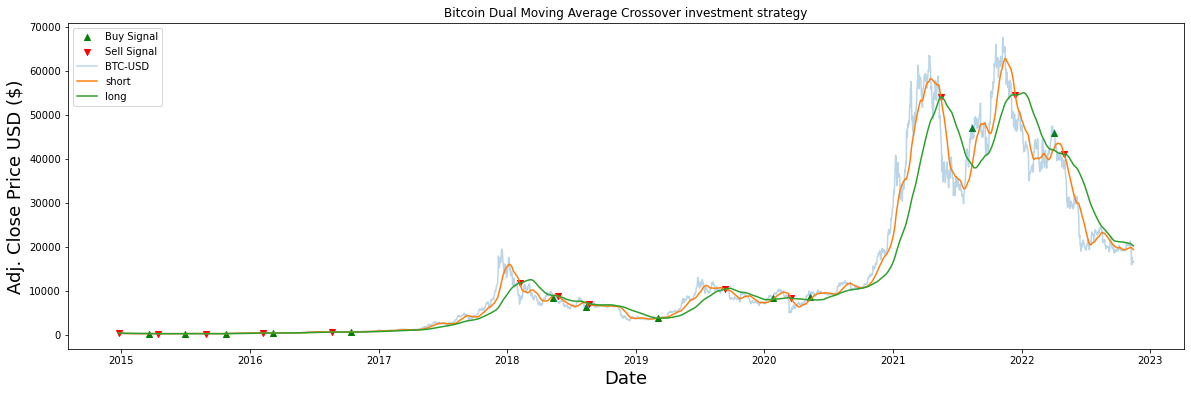

In [2]:
# Graficamos

title = 'Bitcoin Dual Moving Average Crossover investment strategy'
my_stocks = signal
ticker = 'BTC-USD'
plt.figure(figsize=(20,6)) 
plt.scatter(my_stocks.index, my_stocks['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
plt.scatter(my_stocks.index, my_stocks['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
plt.plot( my_stocks[ticker],  label=ticker, alpha = 0.3)
plt.plot( my_stocks['short'],  label='short', alpha = 1)
plt.plot( my_stocks['long'],  label='long', alpha = 1)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Close Price USD ($)',fontsize=18)
plt.legend( loc='upper left')
plt.show()

In [3]:
# Generamos historicos resumido y completo

primer_compra = signal[signal['Buy_Signal_Price'].notnull()].index.min()
simul_inv = signal[signal.index >= primer_compra]
simul_inv['Buy_Signal_Price'] = simul_inv['Buy_Signal_Price']*(-1)
simul_inv = simul_inv[['Buy_Signal_Price','Sell_Signal_Price']]

# Me guardo copia de la versión completa para usar más adeleante, avanzo con versión resumida
simul_inv_completa = simul_inv.copy()

#Sigo con el anterior
simul_inv = simul_inv[ (simul_inv['Buy_Signal_Price'].notnull()) | (simul_inv['Sell_Signal_Price'].notnull()) ]
simul_inv = simul_inv.fillna(0)
simul_inv['ganancia'] = simul_inv['Buy_Signal_Price'] + simul_inv['Sell_Signal_Price']
simul_inv['ganancia_acumulada'] = simul_inv['ganancia']
simul_inv['ganancia_acumulada'] = simul_inv['ganancia_acumulada'].cumsum()

simul_inv.reset_index(inplace=True)
simul_inv['Periodo'] = simul_inv['Date'].diff().dt.days
simul_inv.set_index('Date',inplace=True)

simul_inv['ganancia'] = round(simul_inv['ganancia'],2)
simul_inv['ganancia_acumulada'] = round(simul_inv['ganancia_acumulada'],2)

# Vuelvo a versión completa

simul_inv_completa = simul_inv_completa.fillna(0)

simul_inv_completa['ganancia'] = simul_inv_completa['Buy_Signal_Price'] + simul_inv_completa['Sell_Signal_Price']
simul_inv_completa['ganancia_acumulada'] = simul_inv_completa['ganancia']
simul_inv_completa['ganancia_acumulada'] = simul_inv_completa['ganancia_acumulada'].cumsum()

simul_inv_completa['ganancia'] = round(simul_inv_completa['ganancia'],2)
simul_inv_completa['ganancia_acumulada'] = round(simul_inv_completa['ganancia_acumulada'],2)

simul_inv_completa['Operacion'] = ''
conditions = [
    simul_inv_completa['ganancia'] < 0,
    simul_inv_completa['ganancia'] > 0
]
values = ['Mantengo activo comprado','Mantengo cash']
simul_inv_completa['Operacion'] = np.select(conditions,values)

simul_inv_completa['Operacion'] = np.where(simul_inv_completa['Operacion']=='0',np.nan,simul_inv_completa['Operacion'])
simul_inv_completa['Operacion'] = simul_inv_completa['Operacion'].fillna(method = 'ffill')

simul_inv_completa['position'] = ''

conditions = [
    simul_inv_completa['ganancia'] > 0,
    simul_inv_completa['ganancia'] < 0
]

values = ['vendo','compro']
simul_inv_completa['position'] = np.select(conditions,values)
simul_inv_completa['position'] = np.where(simul_inv_completa['position']=='0',np.nan,simul_inv_completa['position'])
simul_inv_completa['position'][0] = 'compra inicial'
simul_inv_completa['position'] = np.where(simul_inv_completa['position'].isna(), simul_inv_completa['Operacion'],simul_inv_completa['position'])
simul_inv_completa.drop('Operacion',axis=1,inplace=True)

simul_inv = simul_inv.merge(simul_inv_completa[['position']],left_index=True,right_index=True,how='left')

In [8]:
# Posición consolidada (último 20 periodos)
simul_inv_completa.head(20)

,Buy_Signal_Price,Sell_Signal_Price,ganancia,ganancia_acumulada,position
Date,,,,,
2015-03-21,-260.024994,0.0,-260.02,-260.02,compra inicial
2015-03-22,0.000000,0.0,0.00,-260.02,Mantengo activo comprado
2015-03-23,0.000000,0.0,0.00,-260.02,Mantengo activo comprado
2015-03-24,0.000000,0.0,0.00,-260.02,Mantengo activo comprado
2015-03-25,0.000000,0.0,0.00,-260.02,Mantengo activo comprado
2015-03-26,0.000000,0.0,0.00,-260.02,Mantengo activo comprado
2015-03-27,0.000000,0.0,0.00,-260.02,Mantengo activo comprado
2015-03-28,0.000000,0.0,0.00,-260.02,Mantengo activo comprado
2015-03-29,0.000000,0.0,0.00,-260.02,Mantengo activo comprado


In [5]:
# Posición resumida (últimas 20 intervenciones)
simul_inv.tail(20)

,Buy_Signal_Price,Sell_Signal_Price,ganancia,ganancia_acumulada,Periodo,position
Date,,,,,,
2015-10-25,-283.679993,0.000000,-283.68,-304.40,57.0,compro
2016-02-08,0.000000,393.812650,393.81,89.41,106.0,vendo
2016-03-08,-413.971985,0.000000,-413.97,-324.56,29.0,compro
2016-08-21,0.000000,604.043611,604.04,279.48,166.0,vendo
2016-10-15,-638.645996,0.000000,-638.65,-359.16,55.0,compro
2018-02-06,0.000000,11769.301001,11769.30,11410.14,479.0,vendo
2018-05-11,-8441.490234,0.000000,-8441.49,2968.65,94.0,compro
2018-05-24,0.000000,8876.855200,8876.86,11845.50,13.0,vendo
2018-08-13,-6297.569824,0.000000,-6297.57,5547.93,81.0,compro


In [6]:
dias = simul_inv.reset_index()
dias = dias['Date'].max().to_numpy() - dias['Date'].min().to_numpy()
dias = dias.astype('timedelta64[D]')
dias = dias / np.timedelta64(1, 'D')

anios = round(dias / 365,2)
print('Durante la ventana de tiempo desde',simul_inv_completa.index.min().to_pydatetime().date(),'hasta',simul_inv_completa.index.max().to_pydatetime().date(),'tuve que reponer de mis ganancias usd',round(simul_inv['ganancia_acumulada'][simul_inv['ganancia_acumulada'] < 0].sum(),2), 'porque la estrategia de inversión no reporto ganancia en algunos periodos, sin embargo la ganancia neta total fue de usd', simul_inv['ganancia_acumulada'][-1],'en',dias,'días, por ende una ganacia promedio por anio de (aprox):' ,round(simul_inv['ganancia_acumulada'][-1]/anios,2),'. De',len(simul_inv),'intervenciones de compra/venta en el mercado, en',len(simul_inv[simul_inv['ganancia_acumulada'] < 0]),'tuve pérdidas. La peor pérdida fue de usd:',simul_inv['ganancia_acumulada'][simul_inv['ganancia_acumulada'] < 0].min(),'y la ronda que más se gano fue de usd:',simul_inv['ganancia_acumulada'][simul_inv['ganancia_acumulada'] > 0].max(),'. Esta estrategia implica un short de',short,'días y un long de',long,'días.')

Durante la ventana de tiempo desde 2015-03-21 hasta 2022-11-14 tuve que reponer de mis ganancias usd -1557.09 porque la estrategia de inversión no reporto ganancia en algunos periodos, sin embargo la ganancia neta total fue de usd 67065.24 en 2599.0 días, por ende una ganacia promedio por anio de (aprox): 9419.28 . De 24 intervenciones de compra/venta en el mercado, en 7 tuve pérdidas. La peor pérdida fue de usd: -359.16 y la ronda que más se gano fue de usd: 71948.31 . Esta estrategia implica un short de 30 días y un long de 100 días.
